In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
bitcoin_df = pd.read_csv('Bitcoin_Data.csv')
bitcoin_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Sep 12, 2024","57,343.17","58,534.36","57,330.10","58,127.01","58,127.01","33,835,707,949"
1,"Sep 11, 2024","57,650.29","57,991.32","55,567.34","57,343.17","57,343.17","37,049,062,672"
2,"Sep 10, 2024","57,020.10","58,029.98","56,419.41","57,648.71","57,648.71","28,857,630,507"
3,"Sep 9, 2024","54,851.89","58,041.13","54,598.43","57,019.54","57,019.54","34,618,096,173"
4,"Sep 8, 2024","54,147.93","55,300.86","53,653.76","54,841.57","54,841.57","18,268,287,531"
...,...,...,...,...,...,...,...
1787,"Oct 22, 2019","8,243.40","8,296.65","8,074.46","8,078.20","8,078.20","16,803,377,857"
1788,"Oct 21, 2019","8,225.12","8,296.69","8,196.42","8,243.72","8,243.72","15,868,748,866"
1789,"Oct 20, 2019","7,997.81","8,281.82","7,949.44","8,222.08","8,222.08","15,504,249,442"
1790,"Oct 19, 2019","7,973.80","8,082.63","7,944.78","7,988.56","7,988.56","13,797,825,640"


In [4]:
bitcoin_df.info()
bitcoin_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1792 non-null   object
 1   Open       1792 non-null   object
 2   High       1792 non-null   object
 3   Low        1792 non-null   object
 4   Close      1792 non-null   object
 5   Adj Close  1792 non-null   object
 6   Volume     1792 non-null   object
dtypes: object(7)
memory usage: 98.1+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
count,1792,1792,1792,1792,1792,1792,1792
unique,1792,1791,1792,1791,1792,1792,1792
top,"Nov 3, 2019","7,410.45","9,379.81","27,375.60","9,235.35","9,235.35","21,132,220,847"
freq,1,2,1,2,1,1,1


In [5]:
bitcoin_df['Close'].equals(bitcoin_df['Adj Close'])

True

In [6]:
bitcoin_df = bitcoin_df.drop("Adj Close", axis=1)
float_cols = bitcoin_df.drop(columns='Date').columns.tolist()
float_cols

['Open', 'High', 'Low', 'Close', 'Volume']

In [7]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
for col in float_cols:
    bitcoin_df[col] = bitcoin_df[col].str.replace(',', '').astype(float)
bitcoin_df.info()
bitcoin_df[float_cols].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1792 non-null   datetime64[ns]
 1   Open    1792 non-null   float64       
 2   High    1792 non-null   float64       
 3   Low     1792 non-null   float64       
 4   Close   1792 non-null   float64       
 5   Volume  1792 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 84.1 KB


,Open,High,Low,Close,Volume
count,1792.000000,1792.000000,1792.000000,1792.000000,1.792000e+03
mean,32420.744799,33138.309581,31655.461847,32446.410631,3.160910e+10
std,18459.373860,18884.410513,17976.283784,18458.010577,1.791040e+10
min,5002.580000,5331.830000,4106.980000,4970.790000,5.331173e+09
25%,17110.322500,17277.392500,16896.640000,17123.640000,2.011813e+10
50%,29355.445000,29901.055000,28961.660000,29365.535000,2.857145e+10
75%,46137.402500,47218.032500,44461.917500,46190.452500,3.868701e+10
max,73079.380000,73750.070000,71334.090000,73083.500000,3.509679e+11


In [8]:
bitcoin_df['Date'].duplicated().sum()

np.int64(0)

In [9]:
bitcoin_df = bitcoin_df.sort_values('Date').reset_index(drop=True)
bitcoin_df

,Date,Open,High,Low,Close,Volume
0,2019-10-18,8100.93,8138.41,7902.16,7973.21,1.565159e+10
1,2019-10-19,7973.80,8082.63,7944.78,7988.56,1.379783e+10
2,2019-10-20,7997.81,8281.82,7949.44,8222.08,1.550425e+10
3,2019-10-21,8225.12,8296.69,8196.42,8243.72,1.586875e+10
4,2019-10-22,8243.40,8296.65,8074.46,8078.20,1.680338e+10
...,...,...,...,...,...,...
1787,2024-09-08,54147.93,55300.86,53653.76,54841.57,1.826829e+10
1788,2024-09-09,54851.89,58041.13,54598.43,57019.54,3.461810e+10
1789,2024-09-10,57020.10,58029.98,56419.41,57648.71,2.885763e+10
1790,2024-09-11,57650.29,57991.32,55567.34,57343.17,3.704906e+10


In [10]:
outliers_IQR = pd.DataFrame()

for col in float_cols:
    Q1 = bitcoin_df[col].quantile(0.25)
    Q3 = bitcoin_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Outlier bounds for {col}: {lower_bound}, {upper_bound}")
    col_outliers = bitcoin_df[(bitcoin_df[col] < lower_bound) | (bitcoin_df[col] > upper_bound)]
    outliers_IQR = pd.concat([outliers_IQR, col_outliers])

outliers_IQR

Outlier bounds for Open: -26430.297499999993, 89678.02249999999
Outlier bounds for High: -27633.56750000001, 92128.99250000001
Outlier bounds for Low: -24451.276249999995, 85809.83374999999
Outlier bounds for Close: -26476.57875, 89790.67125
Outlier bounds for Volume: -7735191238.125, 66540324662.875


,Date,Open,High,Low,Close,Volume
147,2020-03-13,5017.83,5838.11,4106.98,5563.71,7.415677e+10
195,2020-04-30,8797.67,9440.65,8533.26,8658.55,6.696463e+10
352,2020-10-04,10550.44,10686.00,10534.39,10669.58,7.125178e+10
426,2020-12-17,21308.35,23642.66,21234.68,22805.16,7.137861e+10
442,2021-01-02,29376.46,33155.12,29091.18,32127.27,6.786542e+10
...,...,...,...,...,...,...
1601,2024-03-06,63776.05,67637.93,62848.67,66106.80,6.875023e+10
1610,2024-03-15,71387.88,72357.13,65630.70,69403.77,7.832045e+10
1614,2024-03-19,67556.13,68106.93,61536.18,61912.77,7.421584e+10
1615,2024-03-20,61930.16,68115.26,60807.79,67913.67,6.679263e+10


In [11]:
outliers_zscore = pd.DataFrame()
for col in float_cols:
    z_scores = np.abs(stats.zscore(bitcoin_df[col]))
    col_outliers = bitcoin_df[z_scores > 3]
    outliers_zscore = pd.concat([outliers_zscore, col_outliers])
outliers_zscore

,Date,Open,High,Low,Close,Volume
448,2021-01-08,39381.77,41946.74,36838.64,40797.61,8.810752e+10
451,2021-01-11,38346.53,38346.53,30549.60,35566.66,1.233206e+11
469,2021-01-29,34318.67,38406.26,32064.81,34316.39,1.178946e+11
479,2021-02-08,38886.83,46203.93,38076.32,46196.46,1.014672e+11
480,2021-02-09,46184.99,48003.72,45166.96,46481.11,9.180985e+10
481,2021-02-10,46469.76,47145.57,43881.15,44918.18,8.730109e+10
493,2021-02-22,57532.74,57533.39,48967.57,54207.32,9.205242e+10
494,2021-02-23,54204.93,54204.93,45290.59,48824.43,1.061025e+11
497,2021-02-26,47180.46,48370.79,44454.84,46339.76,3.509679e+11
548,2021-04-18,60701.89,61057.46,52829.54,56216.18,9.746887e+10


In [12]:
minmax_scaler = MinMaxScaler()
minmax_scaled_df = bitcoin_df.copy()
minmax_scaled_df[float_cols] = minmax_scaler.fit_transform(bitcoin_df[float_cols])
minmax_scaled_df

,Date,Open,High,Low,Close,Volume
0,2019-10-18,0.045513,0.041021,0.056453,0.044080,0.029859
1,2019-10-19,0.043645,0.040206,0.057087,0.044306,0.024496
2,2019-10-20,0.043998,0.043117,0.057156,0.047734,0.029433
3,2019-10-21,0.047337,0.043334,0.060830,0.048052,0.030487
4,2019-10-22,0.047605,0.043334,0.059016,0.045622,0.033192
...,...,...,...,...,...,...
1787,2024-09-08,0.721910,0.730347,0.737006,0.732180,0.037430
1788,2024-09-09,0.732251,0.770398,0.751058,0.764156,0.084733
1789,2024-09-10,0.764101,0.770235,0.778145,0.773393,0.068067
1790,2024-09-11,0.773358,0.769670,0.765470,0.768908,0.091767


In [13]:
standard_scaler = StandardScaler()
standard_scaled_df = bitcoin_df.copy()
standard_scaled_df[float_cols] = standard_scaler.fit_transform(bitcoin_df[float_cols])
standard_scaled_df

,Date,Open,High,Low,Close,Volume
0,2019-10-18,-1.317846,-1.324207,-1.321738,-1.326255,-0.891212
1,2019-10-19,-1.324734,-1.327162,-1.319366,-1.325423,-0.994743
2,2019-10-20,-1.323433,-1.316611,-1.319107,-1.312768,-0.899441
3,2019-10-21,-1.311116,-1.315824,-1.305364,-1.311596,-0.879084
4,2019-10-22,-1.310125,-1.315826,-1.312150,-1.320566,-0.826886
...,...,...,...,...,...,...
1787,2024-09-08,1.177356,1.173917,1.224082,1.213642,-0.745072
1788,2024-09-09,1.215502,1.319065,1.276647,1.331671,0.168050
1789,2024-09-10,1.332993,1.318475,1.377974,1.365767,-0.153667
1790,2024-09-11,1.367142,1.316427,1.330562,1.349209,0.303817


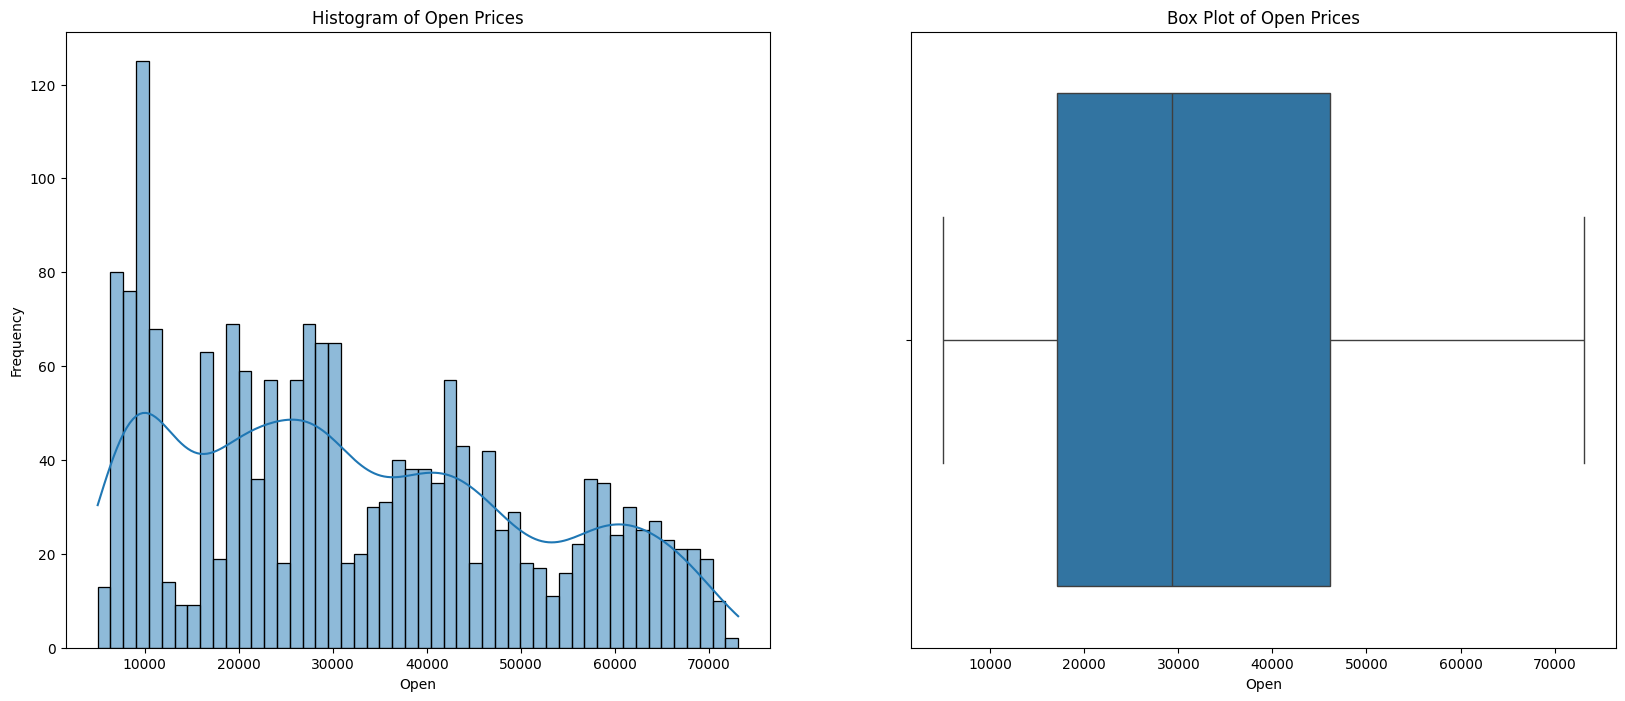

In [14]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_df['Open'], bins=50, kde=True)
plt.title('Histogram of Open Prices')
plt.xlabel('Open')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=bitcoin_df['Open'])
plt.title('Box Plot of Open Prices')
plt.xlabel('Open')

plt.show()

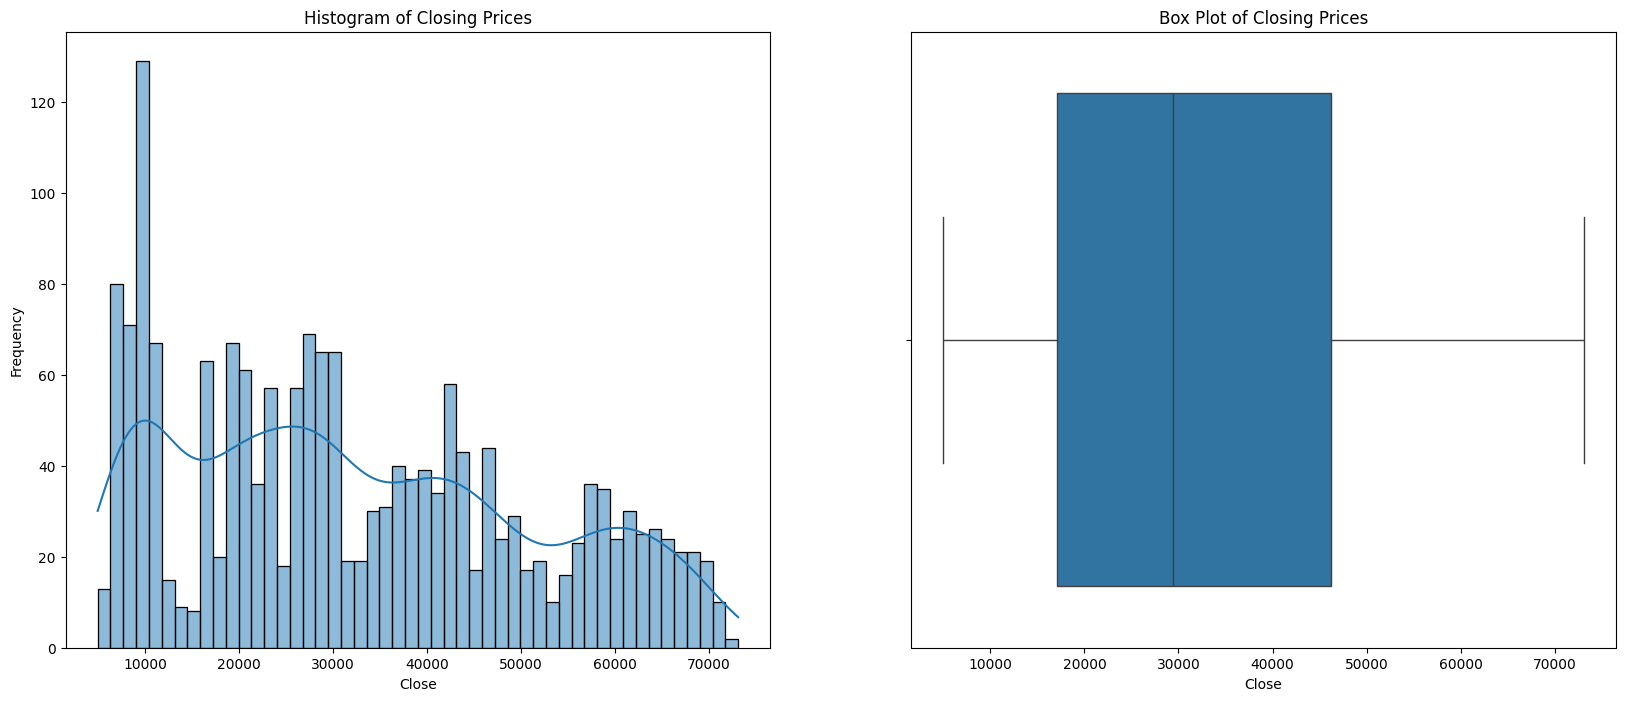

In [15]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_df['Close'], bins=50, kde=True)
plt.title('Histogram of Closing Prices')
plt.xlabel('Close')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=bitcoin_df['Close'])
plt.title('Box Plot of Closing Prices')
plt.xlabel('Close')

plt.show()

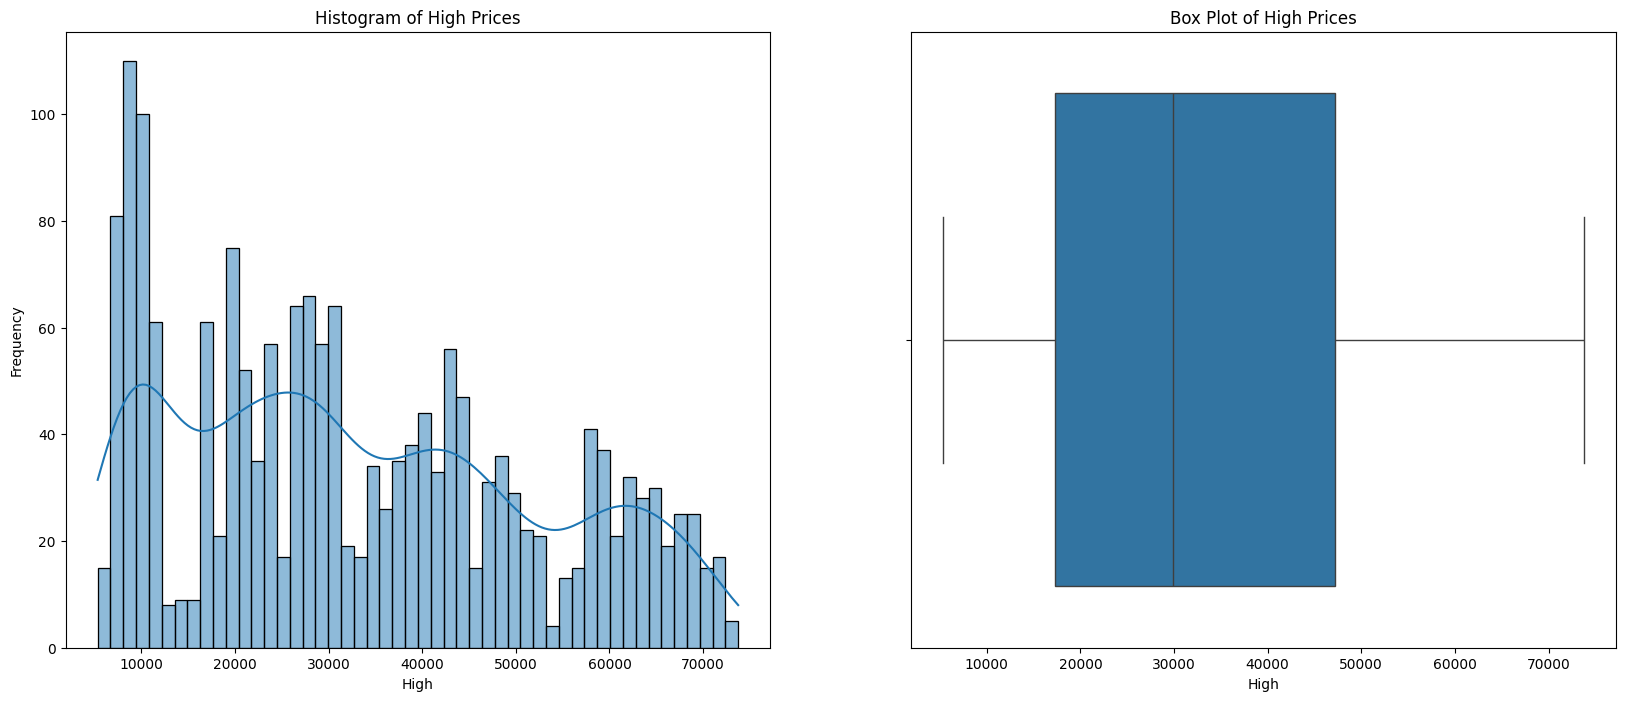

In [16]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_df['High'], bins=50, kde=True)
plt.title('Histogram of High Prices')
plt.xlabel('High')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=bitcoin_df['High'])
plt.title('Box Plot of High Prices')
plt.xlabel('High')

plt.show()

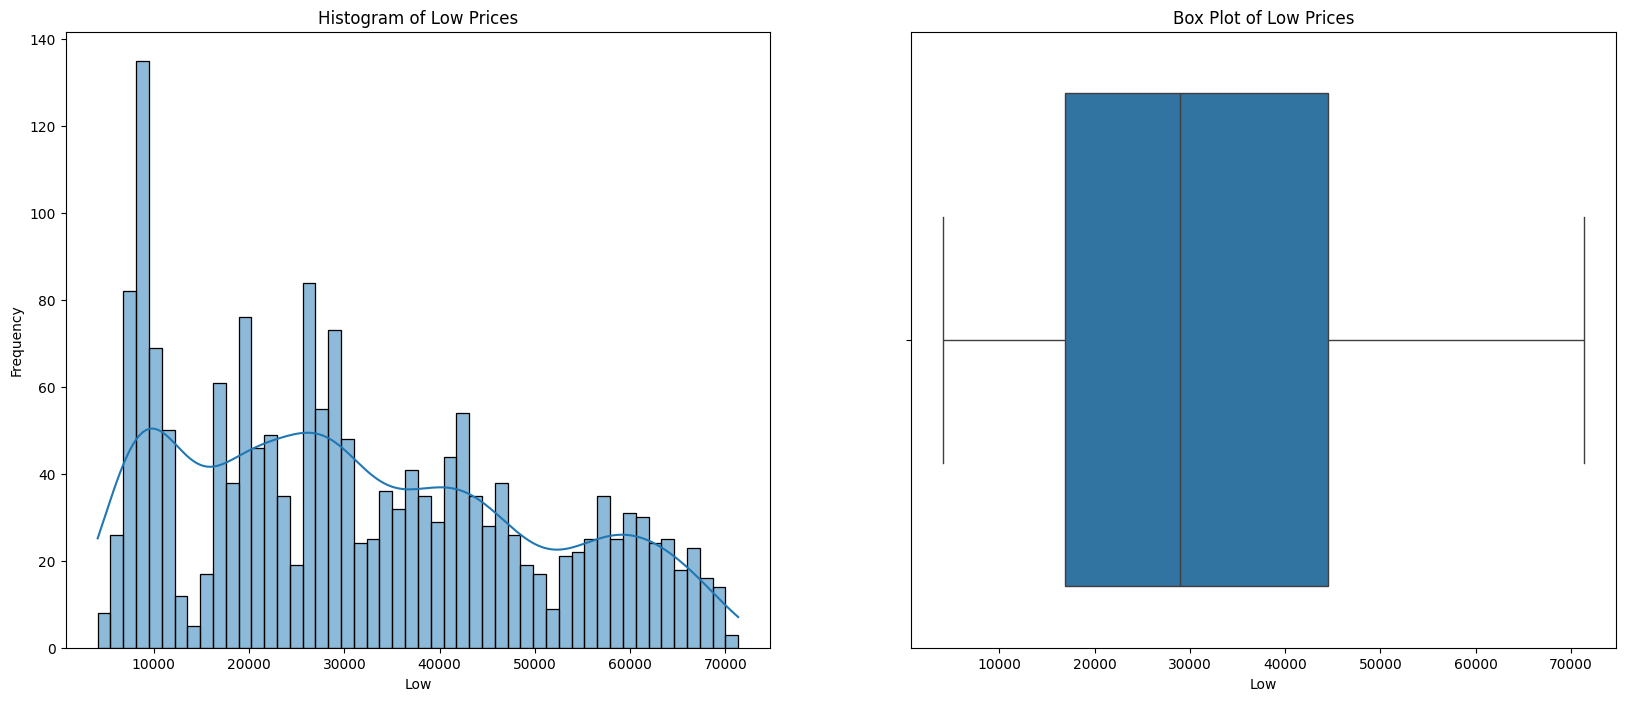

In [17]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_df['Low'], bins=50, kde=True)
plt.title('Histogram of Low Prices')
plt.xlabel('Low')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=bitcoin_df['Low'])
plt.title('Box Plot of Low Prices')
plt.xlabel('Low')

plt.show()

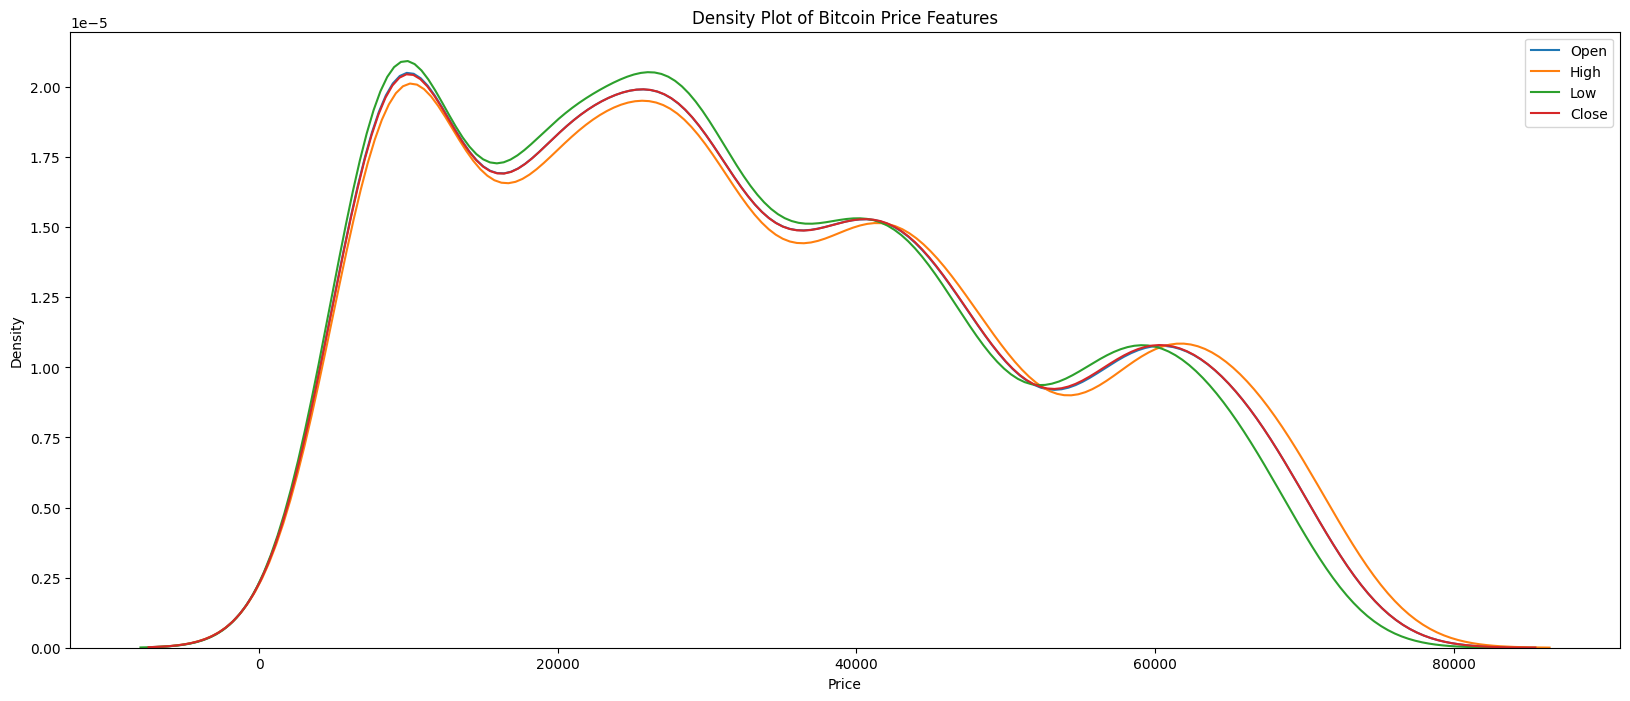

In [18]:
plt.figure(figsize=(20, 8))
for col in ['Open', 'High', 'Low', 'Close']:
    sns.kdeplot(bitcoin_df[col], label=col)
plt.title('Density Plot of Bitcoin Price Features')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

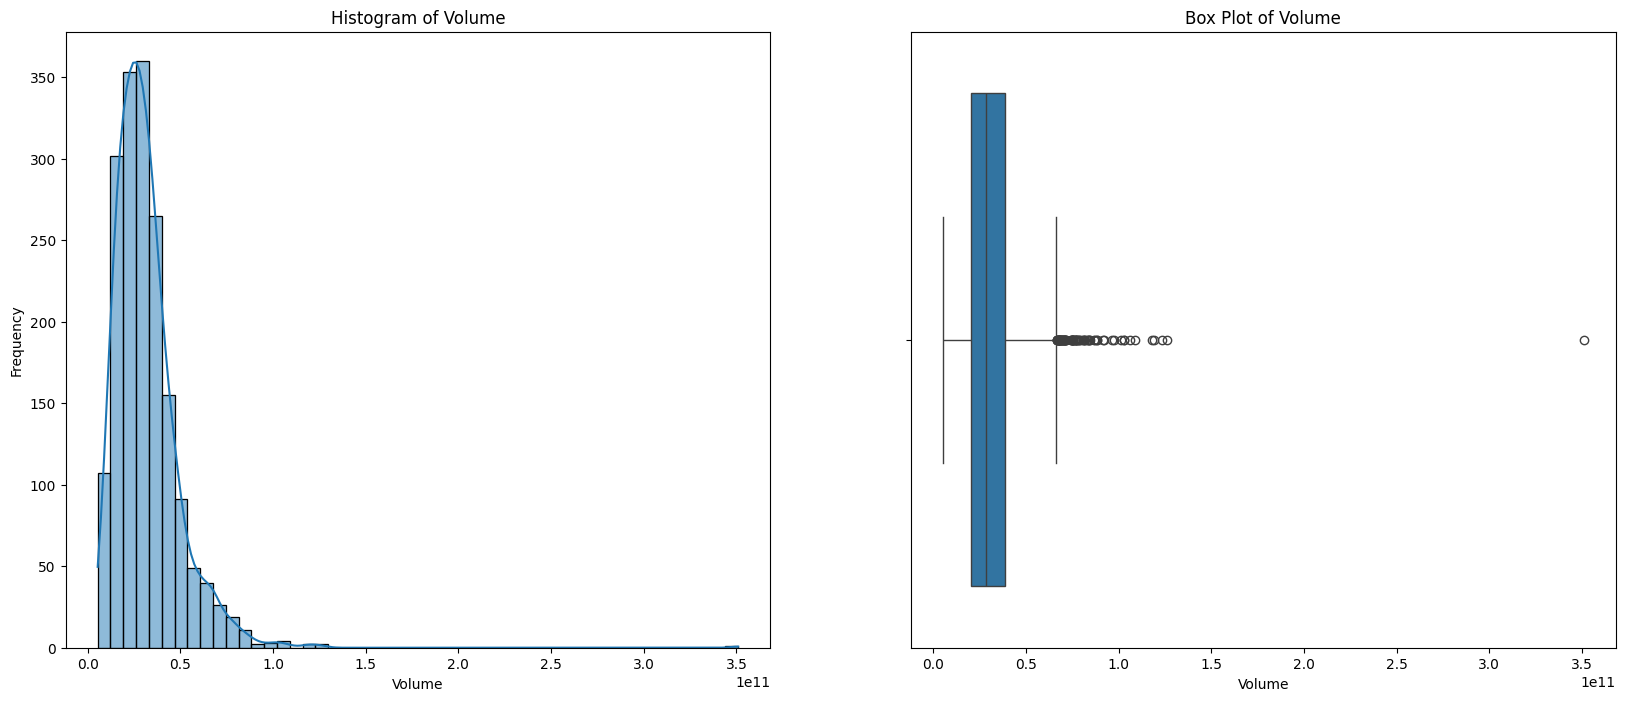

In [19]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_df['Volume'], bins=50, kde=True)
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=bitcoin_df['Volume'])
plt.title('Box Plot of Volume')
plt.xlabel('Volume')

plt.show()

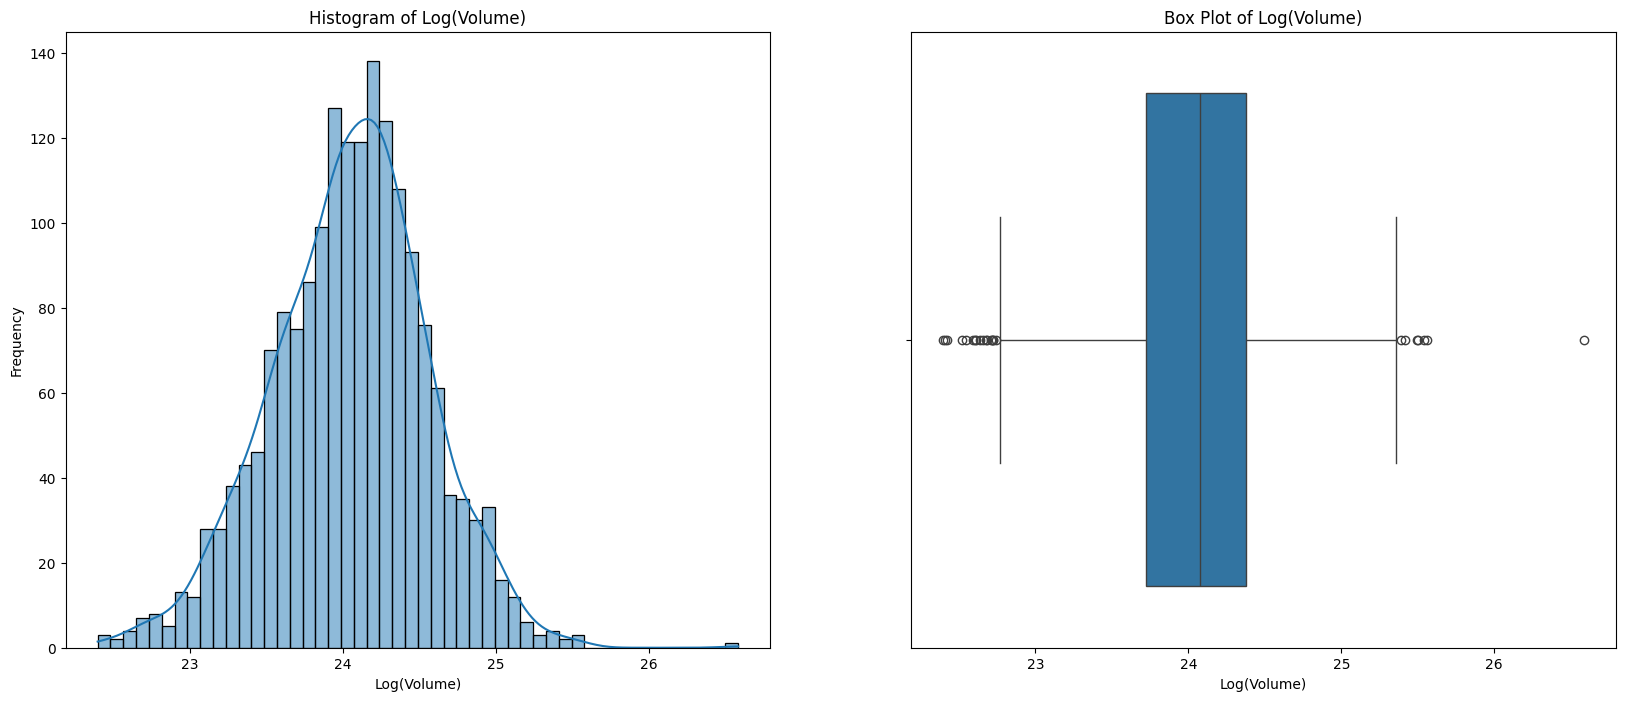

In [20]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(np.log1p(bitcoin_df['Volume']), bins=50, kde=True)
plt.title('Histogram of Log(Volume)')
plt.xlabel('Log(Volume)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=np.log1p(bitcoin_df['Volume']))
plt.title('Box Plot of Log(Volume)')
plt.xlabel('Log(Volume)')

plt.show()

In [21]:
bitcoin_df["Log Volume"] = np.log1p(bitcoin_df['Volume'])
bitcoin_df.info()
bitcoin_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1792 non-null   datetime64[ns]
 1   Open        1792 non-null   float64       
 2   High        1792 non-null   float64       
 3   Low         1792 non-null   float64       
 4   Close       1792 non-null   float64       
 5   Volume      1792 non-null   float64       
 6   Log Volume  1792 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 98.1 KB


,Date,Open,High,Low,Close,Volume,Log Volume
count,1792,1792.000000,1792.000000,1792.000000,1792.000000,1.792000e+03,1792.000000
mean,2022-03-31 12:00:00,32420.744799,33138.309581,31655.461847,32446.410631,3.160910e+10,24.048839
min,2019-10-18 00:00:00,5002.580000,5331.830000,4106.980000,4970.790000,5.331173e+09,22.396837
25%,2021-01-07 18:00:00,17110.322500,17277.392500,16896.640000,17123.640000,2.011813e+10,23.724887
50%,2022-03-31 12:00:00,29355.445000,29901.055000,28961.660000,29365.535000,2.857145e+10,24.075674
75%,2023-06-22 06:00:00,46137.402500,47218.032500,44461.917500,46190.452500,3.868701e+10,24.378770
max,2024-09-12 00:00:00,73079.380000,73750.070000,71334.090000,73083.500000,3.509679e+11,26.583961
std,NaN,18459.373860,18884.410513,17976.283784,18458.010577,1.791040e+10,0.507509


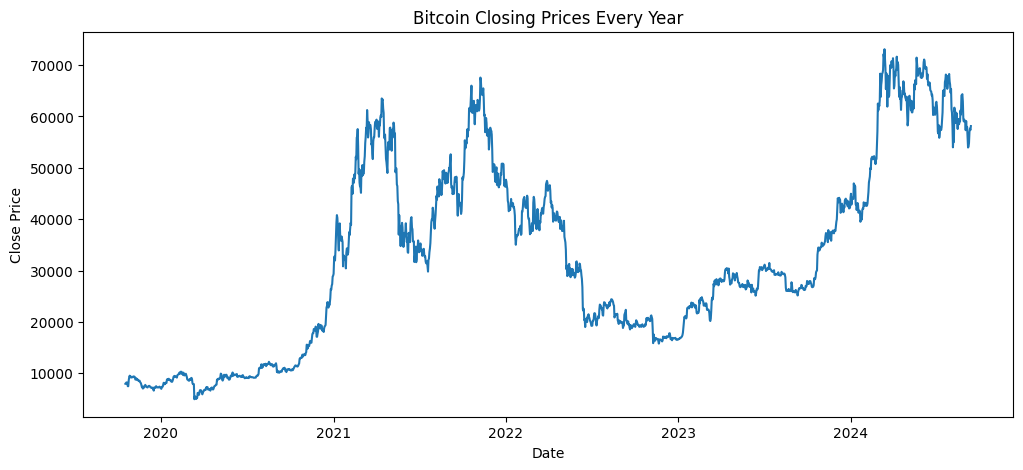

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(bitcoin_df['Date'], bitcoin_df['Close'])
plt.title('Bitcoin Closing Prices Every Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

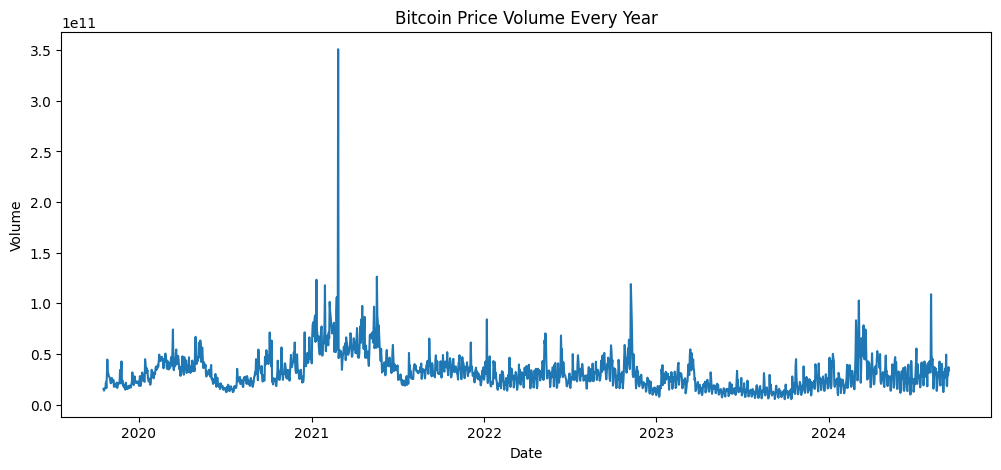

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(bitcoin_df['Date'], bitcoin_df['Volume'], label='Close Price')
plt.title('Bitcoin Price Volume Every Year')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

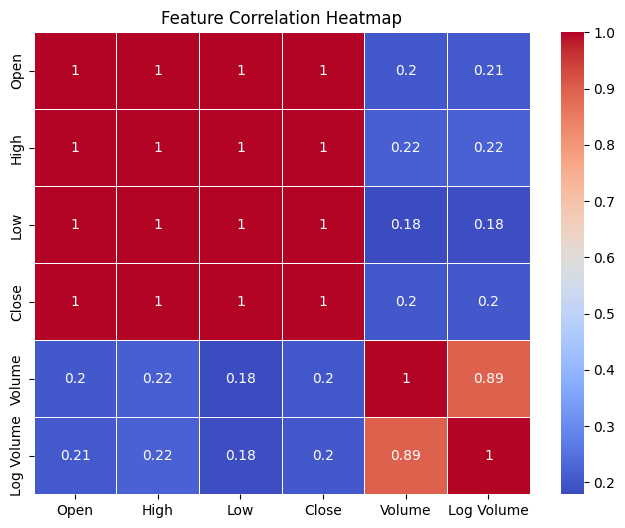

In [24]:
correlation_matrix = bitcoin_df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

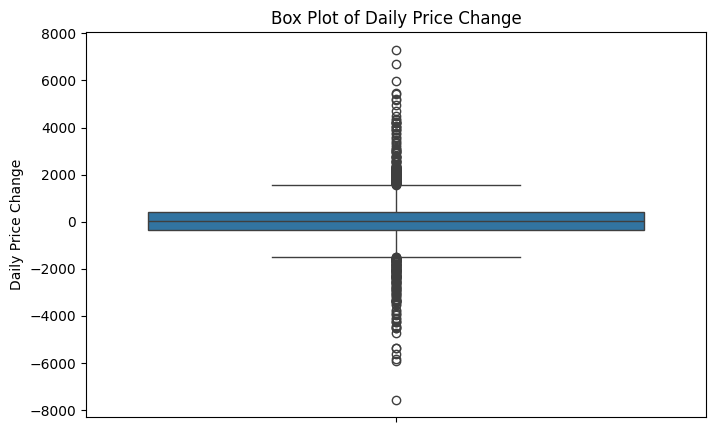

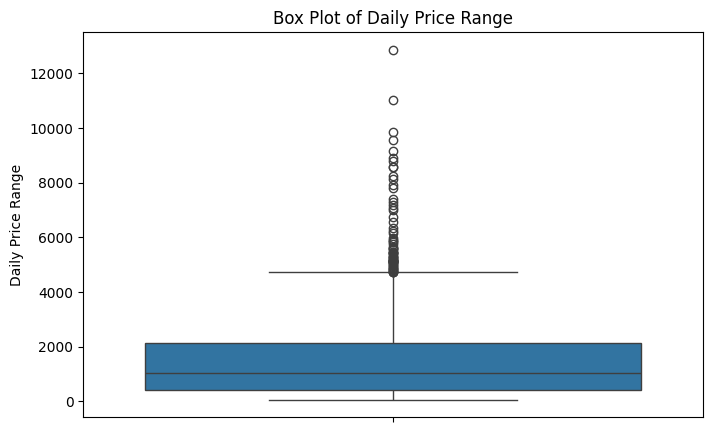

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=(bitcoin_df['Close'] - bitcoin_df['Open']))
plt.title('Box Plot of Daily Price Change')
plt.ylabel('Daily Price Change')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(y=(bitcoin_df['High'] - bitcoin_df['Low']))
plt.title('Box Plot of Daily Price Range')
plt.ylabel('Daily Price Range')
plt.show()

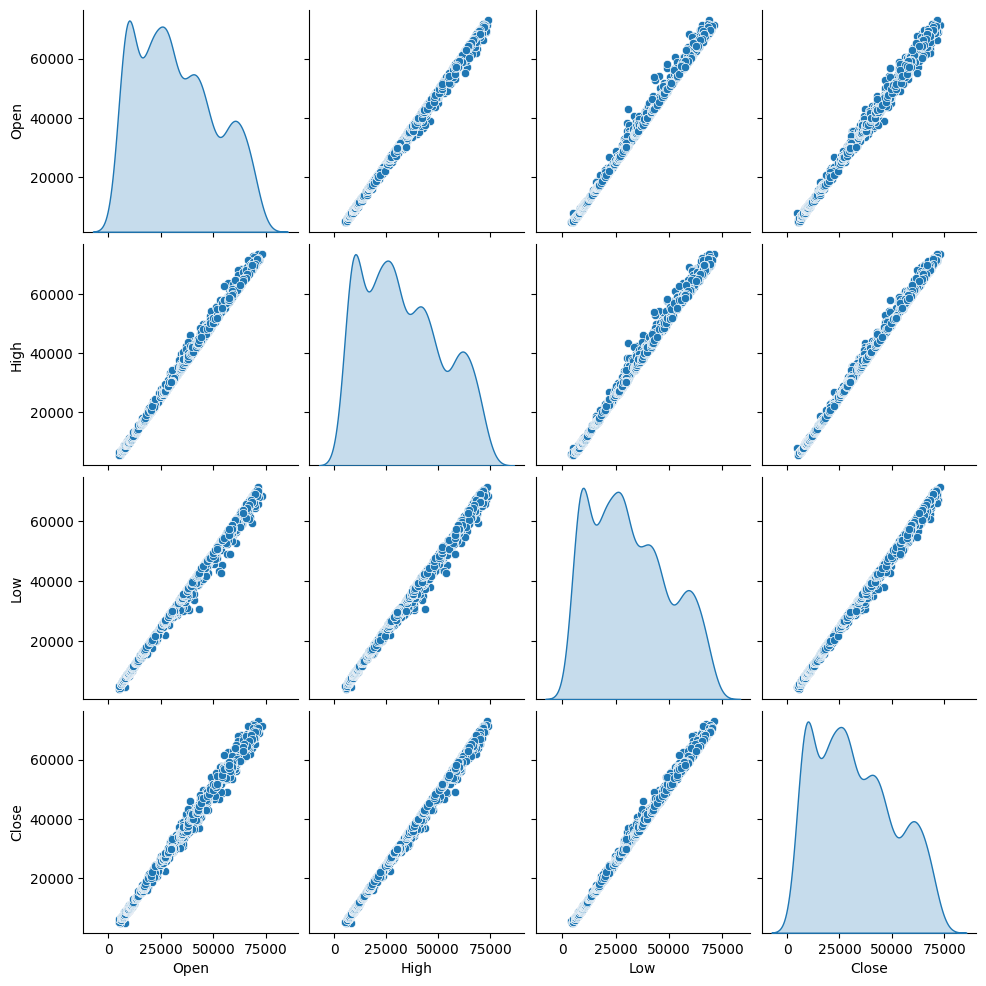

In [26]:
sns.pairplot(bitcoin_df[['Open', 'High', 'Low', 'Close']], diag_kind='kde')
plt.show()

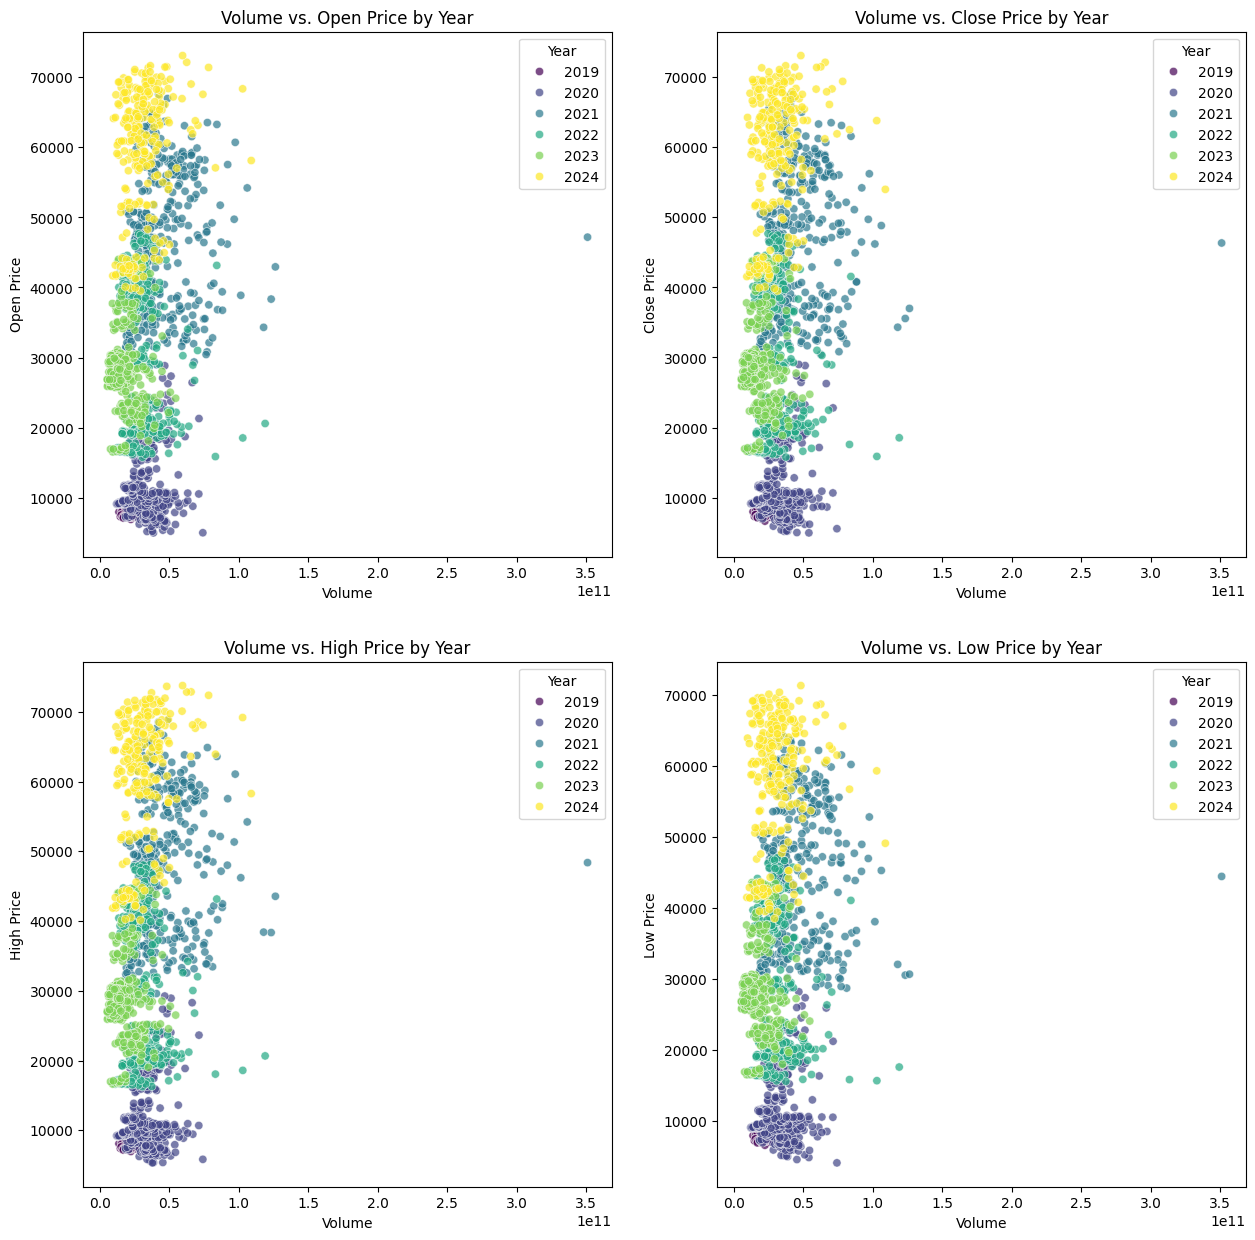

In [27]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.scatterplot(x='Volume', y='Open', hue=bitcoin_df['Date'].dt.year, data=bitcoin_df, palette='viridis', alpha=0.7)
plt.title('Volume vs. Open Price by Year')
plt.xlabel('Volume')
plt.ylabel('Open Price')
plt.legend(title='Year')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Volume', y='Close', hue=bitcoin_df['Date'].dt.year, data=bitcoin_df, palette='viridis', alpha=0.7)
plt.title('Volume vs. Close Price by Year')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.legend(title='Year')

plt.subplot(2, 2, 3)
sns.scatterplot(x='Volume', y='High', hue=bitcoin_df['Date'].dt.year, data=bitcoin_df, palette='viridis', alpha=0.7)
plt.title('Volume vs. High Price by Year')
plt.xlabel('Volume')
plt.ylabel('High Price')
plt.legend(title='Year')

plt.subplot(2, 2, 4)
sns.scatterplot(x='Volume', y='Low', hue=bitcoin_df['Date'].dt.year, data=bitcoin_df, palette='viridis', alpha=0.7)
plt.title('Volume vs. Low Price by Year')
plt.xlabel('Volume')
plt.ylabel('Low Price')
plt.legend(title='Year')

plt.show()

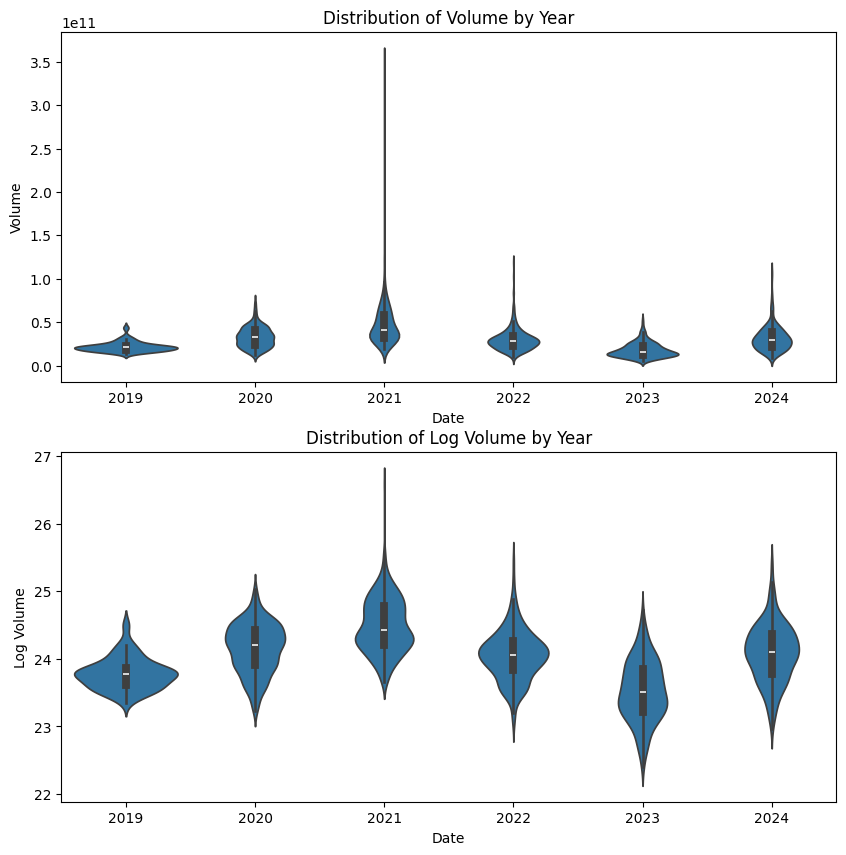

In [28]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
sns.violinplot(x=bitcoin_df['Date'].dt.year, y=bitcoin_df['Volume'], data=bitcoin_df)
plt.title('Distribution of Volume by Year')

plt.subplot(2, 1, 2)
sns.violinplot(x=bitcoin_df['Date'].dt.year, y=bitcoin_df['Log Volume'], data=bitcoin_df)
plt.title('Distribution of Log Volume by Year')

plt.show()

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features and target
X = bitcoin_df[['Open', 'High', 'Low', 'Log Volume']]   # No Close
y = bitcoin_df['Close']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_

# Show feature importances
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


Open: 0.0070
High: 0.8112
Low: 0.1816
Log Volume: 0.0002


In [30]:
X = bitcoin_df[['High', 'Low', 'Log Volume', 'Open']]
y = bitcoin_df['Close']


In [31]:
X_Wout_lo = bitcoin_df[['High', 'Low']]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from sklearn.model_selection import train_test_split

X_train_lo, X_test_lo, y_train, y_test = train_test_split(X_Wout_lo, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled_lo = scaler.fit_transform(X_train_lo)
X_test_scaled_lo = scaler.transform(X_test_lo)

In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_lo = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_lo.fit(X_train_scaled_lo, y_train)

LinearRegression()

In [37]:
# Get feature coefficients
coefficients = lr.coef_

# Show the coefficients with feature names
feature_importance = pd.DataFrame(coefficients, index=X.columns, columns=["Coefficient"])
print(feature_importance)

coefficients_lo = lr_lo.coef_

# Show the coefficients with feature names
feature_importance_lo = pd.DataFrame(coefficients_lo, index=X_Wout_lo.columns, columns=["Coefficient"])
print(feature_importance_lo)

             Coefficient
High        61991.486558
Low         43006.747088
Log Volume    -95.321979
Open       -37437.164652
       Coefficient
High  37414.840030
Low   30407.846976


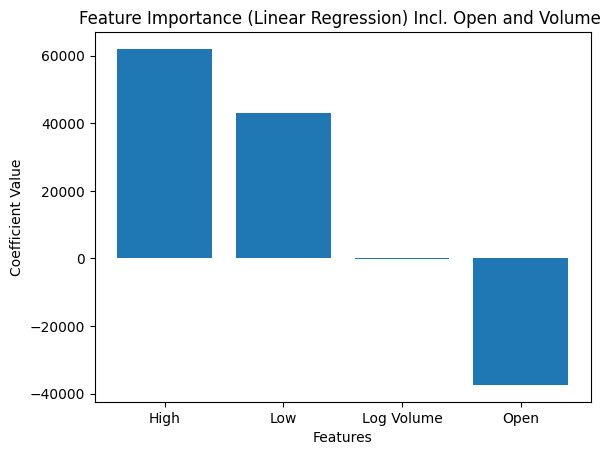

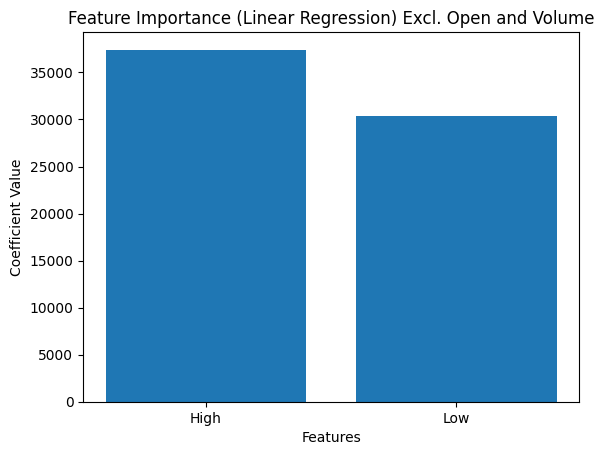

In [38]:
import matplotlib.pyplot as plt

# Plotting the coefficients
plt.bar(feature_importance.index, feature_importance['Coefficient'])
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression) Incl. Open and Volume ')
plt.show()


# Plotting the coefficients
plt.bar(feature_importance_lo.index, feature_importance_lo['Coefficient'])
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression) Excl. Open and Volume')
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Evaluation including Volume and Open Features")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")


y_pred_lo = lr_lo.predict(X_test_scaled_lo)

mse_lo = mean_squared_error(y_test, y_pred_lo)
mae_lo = mean_absolute_error(y_test, y_pred_lo)
r2_lo = r2_score(y_test, y_pred)
print("-------------------------------------------------")
print("Model Evaluation without Volume and Open Features")
print(f"MSE: {mse_lo}")
print(f"MAE: {mae_lo}")
print(f"R^2 Score: {r2_lo}")


Model Evaluation including Volume and Open Features
MSE: 198245.7110447902
MAE: 285.98288736274634
R^2 Score: 0.9994179687058437
-------------------------------------------------
Model Evaluation without Volume and Open Features
MSE: 403398.2934588323
MAE: 404.0353113987937
R^2 Score: 0.9994179687058437


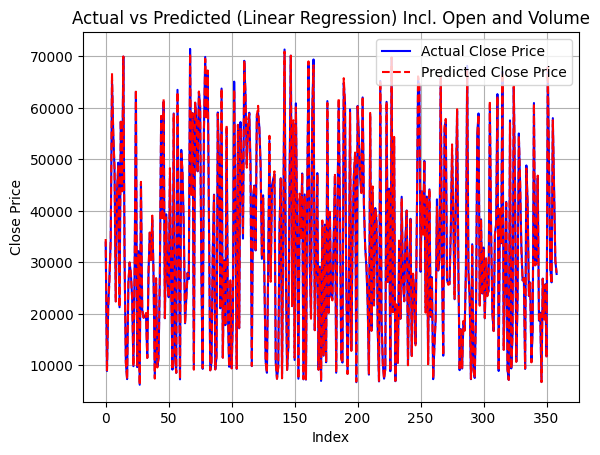

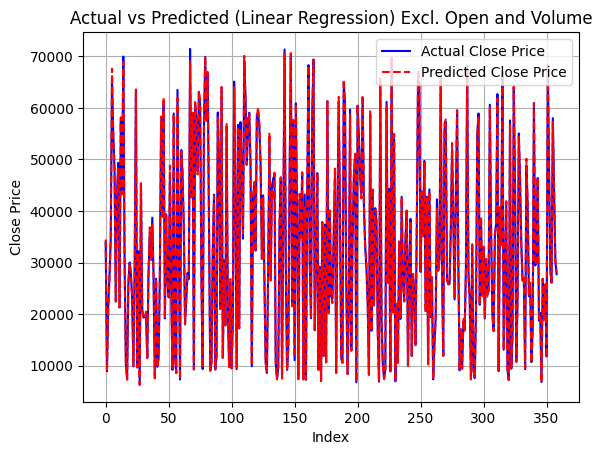

In [40]:
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted (Linear Regression) Incl. Open and Volume')
plt.legend()
plt.grid()
plt.show()




plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred_lo, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted (Linear Regression) Excl. Open and Volume')
plt.legend()
plt.grid()
plt.show()


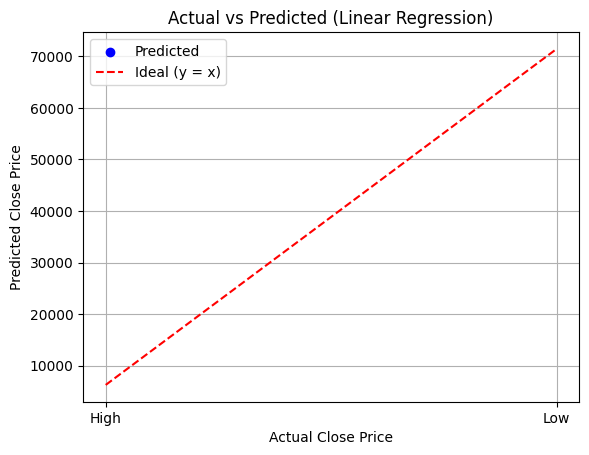

In [41]:
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot([min(X_test_lo), max(X_test_lo)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted (Linear Regression)')
plt.legend()
plt.grid()
plt.show()


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Let's assume df is your original dataframe

# Step 1: Select the relevant features for PCA (all numeric features except 'Date')
features = bitcoin_df[['Open', 'High', 'Low', 'Log Volume']]

# Step 2: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply PCA and specify the number of components you want to keep (let's try to keep most of the variance)
pca = PCA(n_components=2)  # You can set this to 2 or 3 based on how much variance you want to preserve
principal_components = pca.fit_transform(features_scaled)

# Step 4: Check the explained variance ratio to understand the contribution of each component
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

# Step 5: Create a new dataframe with the transformed features (principal components)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 6: You can now proceed with training models using this reduced set of features
print(pca_df.head())

# Step 7: Check the importance of original features in each principal component
print(f'PCA Components (weights of original features):\n{pca.components_}')


Explained Variance Ratio: [0.76421223 0.23521999]
        PC1       PC2
0 -2.446459 -0.732067
1 -2.492492 -0.976294
2 -2.446950 -0.750822
3 -2.423982 -0.708530
4 -2.408309 -0.596679
PCA Components (weights of original features):
[[ 0.56935023  0.57008619  0.56795668  0.16812867]
 [-0.09429998 -0.07929303 -0.11757749  0.98539112]]


Mean Squared Error: 715642.5872103258
Mean Absolute Error: 526.9901488987335
R-squared: 0.9978989387513494


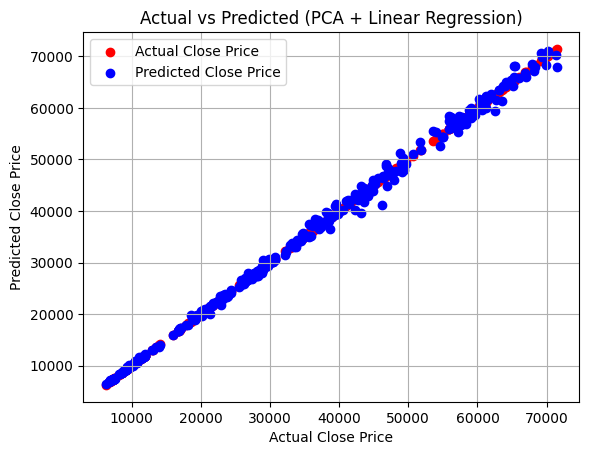

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Assuming 'df' is your DataFrame containing features: Open, High, Low, Volume

# Split the data into features (X) and target (y)
X = bitcoin_df[['Open', 'High', 'Low', 'Log Volume']]  # features
y = bitcoin_df['Close']  # target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on the training data
X_test_scaled = scaler.transform(X_test)  # Only transform on the test data

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit and transform on training data
X_test_pca = pca.transform(X_test_scaled)  # Only transform on test data

# Train a Linear Regression model using the PCA-transformed data
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Optionally, plot actual vs predicted
import matplotlib.pyplot as plt

# Scatter plot with different colors for actual and predicted values
plt.scatter(y_test, y_test, color='red', label='Actual Close Price')  # Actual values
plt.scatter(y_test, y_pred, color='blue', label='Predicted Close Price')  # Predicted values

plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted (PCA + Linear Regression)')
plt.legend()  # Add a legend to differentiate the points
plt.grid()
plt.show()